In [4]:
# load packages
library(edgeR)
library(sva)
library(fgsea)
library(tidyr)
source('../ABCA7lof2//degs.r')
set.seed(5)

In [5]:
# functions
compute_degs = function (counts.df, mod1, mod0,var, n.sv = NULL)
{
    dge <- DGEList(counts = counts.df)
    dge <- calcNormFactors(dge)

    v <- voom(dge, design = mod1)
    if (is.null(n.sv)) {
        n.sv <- num.sv(v$E, mod1, method = "be")
    }
    svobj <- sva(v$E, mod1, mod0, n.sv = n.sv)
    mod1 <- cbind(mod1, svobj$sv)
    v <- voom(dge, design = mod1)
    fit <- lmFit(v, design = mod1)
    fit <- eBayes(fit)
    #res1 <- topTable(fit, coef = "rs3752246", n = Inf, sort.by = "p")
    res1 <- topTable(fit, coef =var, n = Inf, sort.by = "p")
    return(list(res1 = res1, C = svobj$sv, mod=mod1))
}

In [7]:
# load Henne Holstege et al data
df = read.csv('../processed_data/holstege_et_al//41588_2022_1208_MOESM4_ESM.csv', skip = 2, header = TRUE)

# merge with ABCA7 variant info
variant_info = read.csv('../raw_data/ROSMAP_WGS/HIGHandMED_coding_annotations_syn11724057_subset.csv', check.names=FALSE)
variant_info$Variant = paste0(variant_info$CHROM,':',variant_info$POS,':',variant_info$REF_x, '>', variant_info$ALT_0)
df = df[,c('Variant', 'REVEL', 'LOF')]
var_info = merge(variant_info, df, by = 'Variant')
var_info = var_info[var_info$GENE=='ABCA7',]


# # add variant categorization info
# var_info$REVEL[is.na(var_info$REVEL)] = 0
# var_info$stage1 = ifelse(var_info$LOF.y==1, 1, 0)
# var_info$stage2 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.75)), 1, 0)
# var_info$stage3 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.50)), 1, 0)
# var_info$stage4 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.25)), 1, 0)
# var_info$stage5 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.40)), 1, 0)
# var_info$stage6 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.30)), 1, 0)
# var_info$stage7 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.20)), 1, 0)

# # # # subset var_info
#var_info = var_info[(var_info$EFFECT=='missense_variant') & var_info$MAF<0.05,]

# # compute / add burden scores
#stages = var_info[,c('LOF.y', 'stage1', 'stage2', 'stage3', 'stage4', 'stage5', 'stage6', 'stage7')]

genotypes = var_info[,unlist(lapply(names(var_info), function(x) sum(startsWith(x, c('ROS', 'MAP', 'SM')))))>0]
genotypes[genotypes=='0/0']=0
genotypes[genotypes=='0/1']=1
genotypes[genotypes=='1/0']=1
genotypes[genotypes=='1/1']=2
df = apply(genotypes,2, function(x){as.numeric(x)})

variant_categories = as.data.frame(colSums(df[var_info$LOF.y==1,]))
# variant_categories$stage1 = colSums(df[stages$stage1==1,])
# variant_categories$stage2 = colSums(df[stages$stage2==1,])
# variant_categories$stage3 = colSums(df[stages$stage3==1,])
# variant_categories$stage4 = colSums(df[stages$stage4==1,])
# variant_categories$stage5 = colSums(df[stages$stage5==1,])
# variant_categories$stage6 = colSums(df[stages$stage6==1,])
# variant_categories$stage7 = colSums(df[stages$stage7==1,])
# variant_categories$high = colSums(df[var_info$IMPACT=='HIGH',])                   
# # add common variant
temp = as.numeric(unlist(genotypes[var_info$ID=='rs3752246',]))                                  
temp = -1*(temp-2)
variant_categories$rs3752246 = temp
# variant_categories$rare_sums = colSums(df)
#variant_categories$weighted_sum = as.numeric(unlist(var_info$REVEL%*%df))

Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”


In [8]:
# load our large snRNAseq dataset
data = readRDS('../processed_data/mathys_et_al/all_summed_cts.rds')

# add variant data to metadata
meta = data$meta
meta = cbind(meta, variant_categories[meta$WGSid,])

In [9]:
# remove individuals from our snRNAseq cohort
all_data = readRDS('../processed_data/single_cell//stats_input_data_0825.rds')

keep = !meta$projid%in%rownames(all_data$summary)
meta = meta[keep,]
ncells = data$ncells[keep]
counts = data$counts[,keep]

In [16]:
expressed = all_data$expressed10

In [10]:
# add batch info
batch_ids = read.csv('../../ADSubtypes/metadata/Fastq_paths_432_PFC_HM_updated_edited.csv')
batch_ids = batch_ids[!duplicated(batch_ids$projid),]
rownames(batch_ids) = batch_ids$projid
meta$seq_batch = batch_ids[rownames(meta),'Batch']

In [17]:
# filter out individuals with too few cells per celltype
keep = ncells>=10
counts_indexed = counts[,keep]
meta_keep = meta[keep,]
meta_keep$niareagansc = as.numeric(meta_keep$niareagansc)

# filter
keep = (rowSums(is.na(meta_keep))==0) & !(is.na(meta_keep[,'colSums(df[var_info$LOF.y == 1, ])']) | (meta_keep[,'colSums(df[var_info$LOF.y == 1, ])']>0)) #& meta_keep$niareagansc%in%(unlist(list('3','4')))
meta_keep2 = meta_keep[keep,]
meta_keep2$apoe = ifelse(meta_keep2$apoe_genotype%in%c(34,44,24), 1, 0)
counts_keep2 = counts_indexed[,keep]
counts_keep2 = counts_keep2[rownames(counts_keep2)%in%expressed$Ex & rowSums(counts_keep2>0)>15,]

In [22]:
meta_keep2$rs3752246_binary = ifelse(meta_keep2$rs3752246>0, 1, 0)

table(meta_keep2$rs3752246_binary)


  0   1 
227 133 

In [26]:
var_info[var_info$ID=='rs3752246',1:30]

,Variant,Var.2,CHROM,POS,REF_x,ALT_0,ALT_1,ALT_2,FILTER_PASS,numalt,⋯,HGVS_C,HGVC_P,LOF.x,NMD,1000Gp3_AF,N -1/-1,N 0/0,N 0/1,N 0/2,N 0/3
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
60,19:1056492:G>C,11413,19,1056492,G,C,,,True,1,⋯,c.4580G>C,p.Gly1527Ala,,,0.825479,0,39,364,0,0


In [622]:
# compute DEGs rs3752246
# remove any LOF individuals

meta_keep2$rs3752246_binary = ifelse(meta_keep2$rs3752246>0, 1, 0)

mod1 <- model.matrix(~rs3752246_binary + amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)
mod0 <- model.matrix(~ amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)

out = compute_degs(counts_keep2, mod1, mod0, 'rs3752246_binary')
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)

Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

In [623]:
# compute fgsea results rs3752246
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      

o = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

In [651]:
x = o[order(o$pval,decreasing=FALSE),]
x$leadingEdge = NULL

write.csv(x, '../processed_data/common_var/rs3755246_cluster_effects.csv')

In [634]:
write.csv(meta_keep2[, c('projid', 'WGSid', 'rs3752246_binary', 'amyloid', 'nft', 'msex', 'age_death', 'apoe', 'pmi', 'seq_batch', 'niareagansc')], '../processed_data/mathys_et_al/data_for_carles.csv', row.names=FALSE)

In [636]:
write.csv(as.data.frame(scores), '../processed_data/common_var/rs3752246_binary_scores.csv')

In [655]:
var_info[var_info$ID=='rs3752246',1:2]

,Variant,Var.2,CHROM,POS,REF_x,ALT_0,ALT_1,ALT_2,FILTER_PASS,numalt,⋯,HGVS_C,HGVC_P,LOF.x,NMD,1000Gp3_AF,N -1/-1,N 0/0,N 0/1,N 0/2,N 0/3
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
60,19:1056492:G>C,11413,19,1056492,G,C,,,True,1,⋯,c.4580G>C,p.Gly1527Ala,,,0.825479,0,39,364,0,0


### below is scrap

In [614]:
# compute DEGs rs3752246
# remove any LOF individuals

meta_keep2$rare_sums = ifelse(meta_keep2$rare_sums>0, 1, 0)

mod1 <- model.matrix(~rare_sums + amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)
mod0 <- model.matrix(~ amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)

out = compute_degs(counts_keep2, mod1, mod0, 'rare_sums')
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)

Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

In [615]:
# compute fgsea results rs3752246
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      

o = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

In [526]:
# compute DEGs weighted sum
meta_keep2$stage = ifelse(meta_keep2$stage3>0, 1, 0)


mod1 <- model.matrix(~weighted_sum + amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)
mod0 <- model.matrix(~ amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)

out = compute_degs(counts_keep2, mod1, mod0, 'weighted_sum')
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)

Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

In [527]:
# compute fgsea results rs3752246
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      

o = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

In [616]:
o[order(o$pval,decreasing=FALSE),]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
7,0.004695886,0.03756708,0.31827968,0.5206892,1.7085514,40,"NDUFC1, ....",2.32828250
2,0.070724765,0.28289906,0.07902990,0.4483919,1.3966391,31,"HMGCS1, ....",1.15042849
4,0.354770017,0.69074890,0.03227336,0.3808170,1.0714465,20,"DDB2, LD....",0.45005309
5,0.414757709,0.69074890,0.02995854,0.3130458,1.0176332,38,"RBX1, MT....",0.38220553
1,0.440131820,0.69074890,0.02564854,-0.3165691,-1.0050959,38,"USP1, FA....",-0.35641723
6,0.558663413,0.69074890,0.02216700,-0.3482817,-0.9307757,18,"C2, MAX,....",-0.25284977
0,0.604405286,0.69074890,0.02346334,0.2804562,0.9116927,38,"IDH1, FH....",0.21867175
3,0.901162791,0.90116279,0.01454464,-0.2268536,-0.7395774,43,"IFT88, C....",-0.04519675


In [320]:
o[order(o$pval,decreasing=FALSE),]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
7,0.1544625,0.9688118,0.05285003,0.3681119,1.2329730,40,"NDUFS3, ....",0.81117695
5,0.2480564,0.9688118,0.03618645,-0.3627033,-1.1502393,38,"POLE2, A....",-0.60544955
0,0.5640933,0.9688118,0.02142629,-0.2952470,-0.9363156,38,"KLKB1, G....",-0.24864906
3,0.5664034,0.9688118,0.02124791,-0.2876081,-0.9346628,43,"PSMD13, ....",-0.24687411
6,0.8723913,0.9688118,0.01762370,0.2559457,0.7067181,18,"PTRH2, B....",0.05928867
4,0.9600370,0.9688118,0.01389331,-0.2190239,-0.5998697,20,"LDLR, AP....",-0.01771203
1,0.9631170,0.9688118,0.01351410,-0.2031065,-0.6441109,38,"RNF168, ....",-0.01632096
2,0.9688118,0.9688118,0.01624148,0.1987398,0.6273882,31,"SIRT7, S....",0.01376059


In [39]:

# add variant info 
temp = data$var_info

rs729 = temp[temp['ID']=='rs72973581','POS']
rs375 = temp[temp['ID']=='rs3752246','POS']

#meta_keep$rs3752246_1 = ifelse(meta_keep[,'1056492']=='0/1', 1, 0)
meta_keep$rs3752246_2 = ifelse(meta_keep[,'1056492']!='1/1', 1, 0)
#meta_keep$rs72973581 = ifelse(meta_keep[,'1043103']=='0/0', 0, ifelse(meta_keep[,'1043103']=='0/1', 1, 2))
print(table(meta_keep$rs3752246_2))
meta_keep = meta_keep[,c('amyloid', 'nft', 'msex', 'age_death', 'pmi', 'seq_batch', 'apoe_genotype', 'rs3752246_2', 'niareagansc')]

# filter
keep = rowSums(is.na(meta_keep))==0 #& meta_keep$niareagansc%in%(unlist(list('3','4')))
meta_keep2 = meta_keep[keep,]
meta_keep2$apoe = ifelse(meta_keep2$apoe_genotype%in%c(34,44,24), 1, 0)
counts_keep2 = counts_indexed[,keep]

counts_keep2 = counts_keep2[rownames(counts_keep2)%in%expressed$Ex & rowSums(counts_keep2>0)>15,]

# compute DEGs
out = compute_degs(counts_keep2, meta_keep2)
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)
scores = scores[order(scores, decreasing = TRUE)]

# compute fgsea results
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      

o = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)


  0   1 
241 136 
Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

In [41]:
write.csv(as.data.frame(scores), '../processed_data/common_var/ex_scoresE4.csv')

In [40]:
o

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
4,0.92600798,0.9260080,0.01702552,-0.2343931,-0.6639091,20,"MDM2, RP....",-0.03338527
6,0.59560842,0.6806953,0.02077039,0.3407706,0.9079523,18,"CASP3, T....",0.22503917
0,0.50579965,0.6743995,0.02269799,0.3050356,0.9682053,38,"CLU, C1S....",0.29602148
1,0.42442882,0.6743995,0.02557152,0.3212969,1.0198197,38,"MRE11, T....",0.37219513
2,0.35261708,0.6743995,0.03387289,-0.3369552,-1.0653238,31,"NCOA1, E....",-0.45269666
5,0.17532468,0.4675325,0.05046611,-0.3631470,-1.2005879,38,"RPA2, DN....",-0.75615696
3,0.13079275,0.4675325,0.05948707,-0.3691121,-1.2493702,43,"PSMA7, P....",-0.88341631
7,0.08743043,0.4675325,0.07293884,-0.3908773,-1.3069889,40,"NDUFB8, ....",-1.05833740


In [348]:
rs729

[1] 1043103

In [352]:
table(meta_keep2$rs3752246, meta_keep2$rs72973581)

   
      0   1
  0 202  38
  1 111   7
  2  17   0

In [213]:
375/20

[1] 18.75

In [333]:
dim(counts_keep2)

[1] 10226   375

In [201]:
dim(counts_keep2)

[1] 10214   375

Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

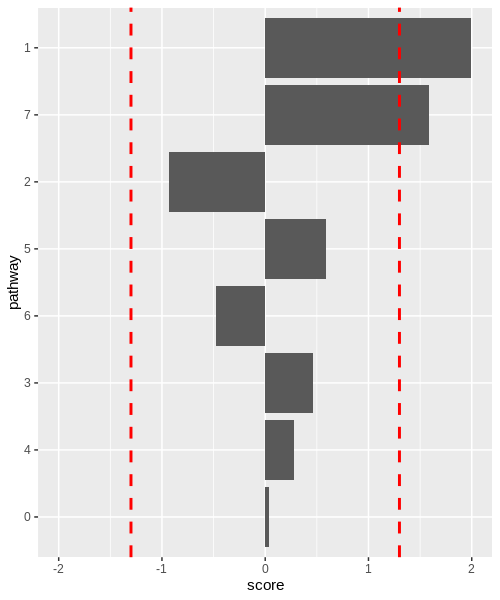

In [361]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1.3,1.3), linetype="dashed", 
                color = "red", size=1)

In [ ]:
# analysis of dose dependency
# show effect size as in figure 2
# missense burden variant analysis as in Holstege et al 

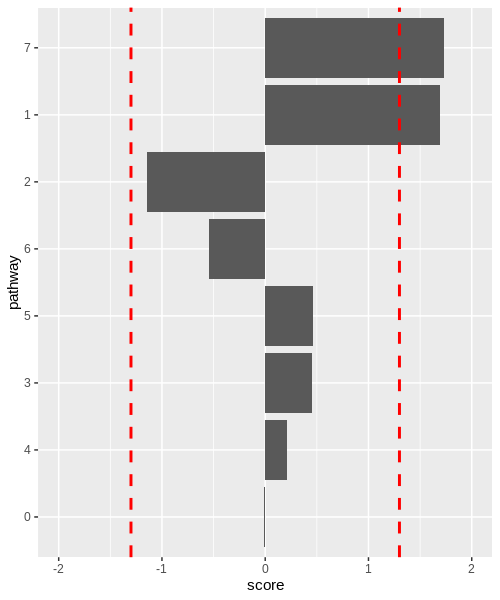

In [340]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1.3,1.3), linetype="dashed", 
                color = "red", size=1)

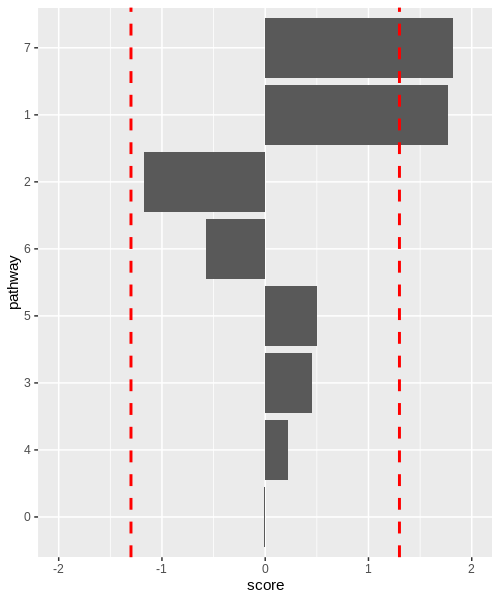

In [259]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1.3,1.3), linetype="dashed", 
                color = "red", size=1)

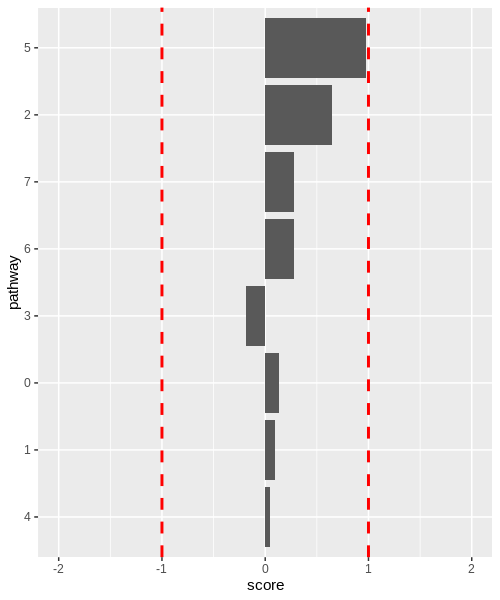

In [242]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


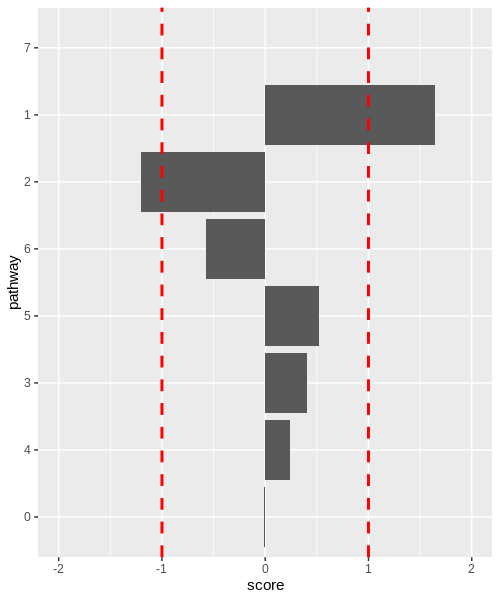

In [208]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

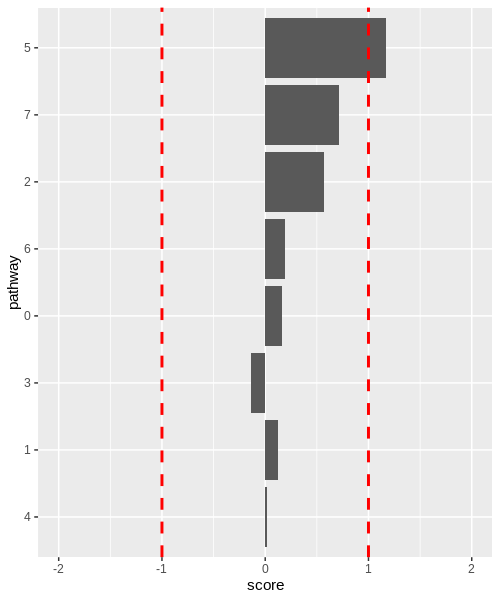

In [190]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

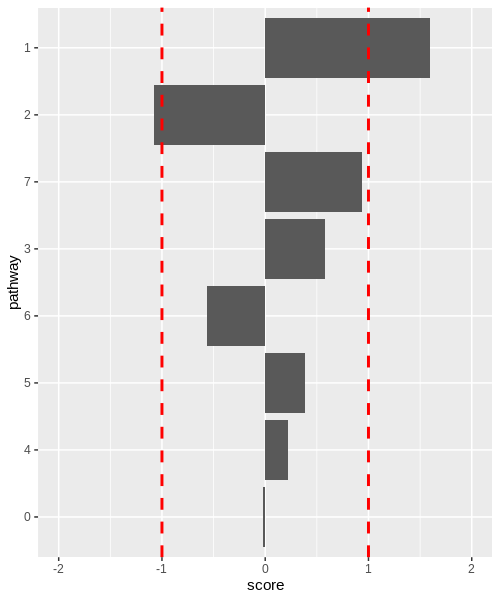

In [141]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

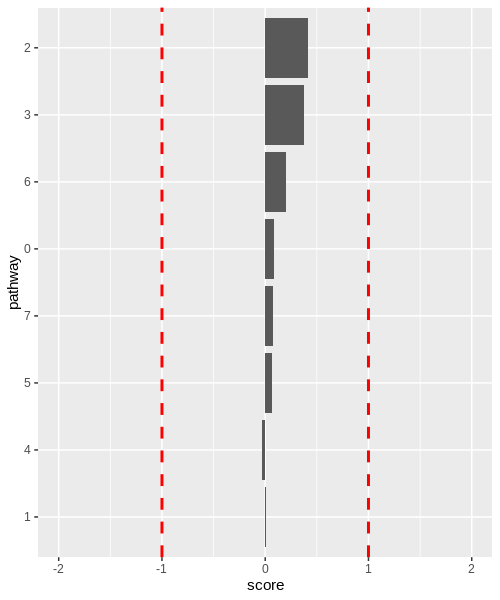

In [117]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

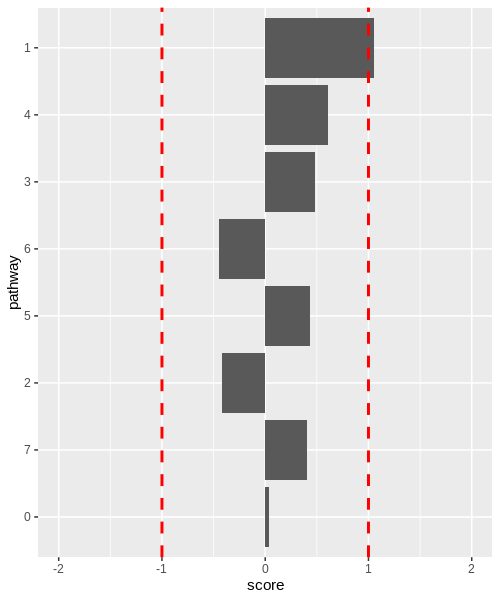

In [101]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

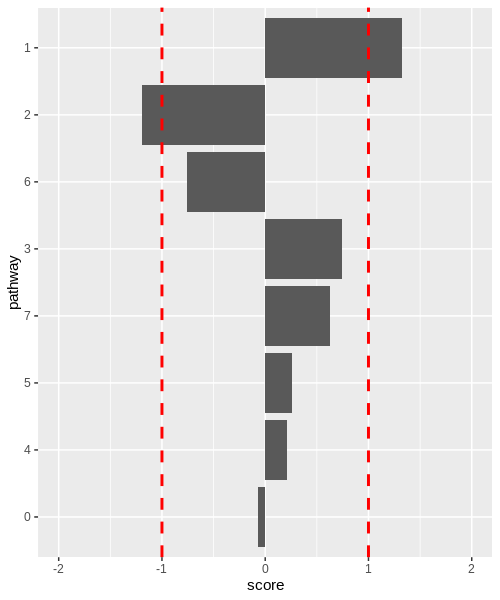

In [66]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)